# CLASSIFICATION OF LAB SAMPLES

This notebook contains the figures for the final classifier.
The classifier is constructed as follows:

* Features: 10 mycbactin genes plus 1 bacterioferritin gene
  * Mycobactin: Rv2377c, Rv2378c, Rv2379c, Rv2380c, Rv2381c, Rv2382c, Rv2383c, Rv2384, Rv2385    , Rv2386c
  * Bacterioferritin gene: Rv3841 
* Counts are averages of 3 replications
* Discard T1, the only normoixia timepoint

# TO DO

# Preliminaries

## Imports

In [5]:
import init
from common import constants as cn
from common_python.util import dataframe
from tools.make_classification_data import ClassificationData
from tools.cross_validation_data import CrossValidationData

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

%matplotlib inline

In [2]:
## Classifier data
data = ClassificationData()
DATA_DCT = data.getDct()

In [3]:
DATA_DCT.keys()

dict_keys(['T0', 'POOLED', 'REF_TYPE_POOLED', 'REF_TYPE_BIOREACTOR', 'REF_TYPE_SELF', 'PROVIDER', 'TRINARY', 'ALL_GENES', 'MYCOBACTIN_GENES', 'BACTERIOFERRITIN_GENES', 'MYCOBACTIN_BACTERIOFERRIN_GENES', 'STAGE_NAMES', 'DATA_DCT', 'SER_Y_DCT', 'DF_X_DCT', 'SAMPLE_DCT', 'SAMPLE_AVG_DCT', 'CLASSIFIER_BASE', 'CLASSIFIER_DCT', 'GENE_GROUPS', 'MYCOBACTIN', 'BACTERIOFERRITIN', 'MYCOBACTIN_BACTERIOFERRITIN', 'ALL', 'TOP12_T0', 'TOP12_POOLED', 'GENE_DCT', 'DF_X', 'SER_Y', 'SAMPLE_DATA_DCT', 'CLASSIFIER', 'GENES', 'DF_ACCURACY'])

## Constants

## Helper Functions

In [ ]:
def evaluateClassifierOnInstances(clf, **kwargs):
    clf.evaluateClassifierOnInstances(**kwargs)

In [ ]:
def plotSampleData(data_dct, genes= None, is_plot=True):
    """
    Plots trinary values of data for the specified genes.
    
    Parameters
    ----------
    data_dct: dict
        key: reference type
        value: sample dictionary
            key: sample name
            value: features
    genes: list-str
    """
    ref_types = list(data_dct.keys())
    sample_names = list(data_dct[ref_types[0]].keys())
    for sample_name in sample_names:
        for ref_type in ref_types:
            df_X = data_dct[ref_type][sample_name]
            if genes is None:
                genes = list(df_X.columns)
            TRINARY.plotExpressionLevels(genes, df_X=df_X, title=ref_type + ", " + sample_name, is_plot=is_plot)
            
# Tests
plotSampleData(SAMPLE_DCT, genes=MYCOBACTIN_BACTERIOFERRIN_GENES, is_plot=False)
print("OK!")

In [ ]:
def reportSamplePredictions(data_dct):
    for name in data_dct.keys():
        df_X = data_dct[name]
        print("\n%s" % name)
        df_pred = CLASSIFIER.predict(df_X)
        new_columns = [STAGE_NAMES[c] for c in df_pred.columns]
        df_pred.columns = new_columns
        print(df_pred)

In [ ]:
def plotAccuracy(genes, title="", selected_stages=None, size=100, is_plot=True, ax=None):
    """
    Plots the accuracy curve for a collection of genes
    
    Parameters
    ----------
    genes: list-str
    title: str
    selected_stages: list-str
        Create a binary classifier for just these tages
    size: int
    is_plot: bol
    """
    if ax is None:
        _, ax = plt.subplots(1)
    accuracy_dct = {}
    #data = mkDataSubset(genes, selected_stages=selected_stages)
    data = DATA_DCT[T0].subsetToStates(selected_stages, genes=genes)
    ranks = range(1, len(genes) + 1)
    for rank in ranks:
        accuracy_dct[rank] = CLASSIFIER.crossValidate(
            data, num_iter=10, num_holdout=1, filter_high_rank=rank, size=size)
    ax.plot(list(accuracy_dct.keys()), list(accuracy_dct.values()), marker="o")
    ax.set_ylim([0, 1.1])
    _ = ax.set_xlabel("No genes in clasifier")
    _ = ax.set_ylabel("accuracy")
    ax.set_title(title)
    if not is_plot:
        plt.close()
    return accuracy_dct
    
# Tests
genes = GENE_DCT["bacterioferritin"]
accuracy_dct = plotAccuracy(GENE_DCT["bacterioferritin"], title=", ".join(genes), selected_stages="StageII", size=5, is_plot=True)
assert(np.isclose(list(accuracy_dct.values())[0], 0.5))
print("OK!")

## Data

### BioReactor

In [ ]:
for ref, df in DF_X_DCT.items():
    TRINARY.plotExpressionLevels(df.columns, title="%s" % ref)

In [ ]:
if FULL_RUN:
    for key, clf in CLASSIFIER_DCT.items():
        suptitle = "%s: Acc=%1.2f" % (", ".join(key), np.mean(CLASSIFIER_DCT[key].scores))
        evaluateClassifierOnInstances(CLASSIFIER_DCT[key], ser_y=DATA_DCT[key[0]].ser_y, nrow=4, ncol=6, 
                                      suptitle=suptitle)

### Lab Samples

**Observations**
1. Prefer control values that avoid having a constant value of the trinary value over the samples (since such a situation is unhelpful for distinguishing classes).
1. On training data (Bioreactor)
   1. Many genes have the same within class values
   1. Few genes have the same between class values

**TO DO**: Plot data in pairs, 1 column, 2 rows; this allows comparisons of the expressions for T0 vs. pooled.

In [ ]:
# With Bioreactor reference data
plotSampleData(SAMPLE_DCT, genes=MYCOBACTIN_BACTERIOFERRIN_GENES)

# Classification Validations on Training Samples
Classify T2-T25 and see if result is same as original class. Use 5-fold cross validation, where there is a holdout for each class and the selection is random.


In [22]:
[k.split("--") for k in df_cv_data.columns]
#["%s--%s" % (k.split()[1], k.split()[0]) for k in df_cv_data.columns]

[['T0', 'mycobactin'],
 ['T0', 'bacterioferritin'],
 ['pooled', 'mycobactin'],
 ['pooled', 'bacterioferritin'],
 ['pooled', 'mycobactin_bacterioferritin'],
 ['pooled', 'all'],
 ['T0', 'mycobactin_bacterioferritin'],
 ['T0', 'all']]

In [29]:
df_new

,mycobactin--T0,bacterioferritin--T0,mycobactin--pooled,bacterioferritin--pooled,mycobactin_bacterioferritin--pooled,all--pooled,mycobactin_bacterioferritin--T0,all--T0
num_gene,,,,,,,,
1,0.5030,0.3940,0.5400,0.3920,0.5600,0.4440,0.4570,0.4584
2,0.5146,0.3924,0.5800,0.3950,0.6282,0.7404,0.4894,0.6030
3,0.6110,0.3958,0.6376,0.3922,0.5622,0.6724,0.6292,0.6126
4,0.5952,0.3922,0.6740,0.3964,0.7038,0.7794,0.7124,0.8174
5,0.6484,0.3984,0.7036,0.3978,0.7134,0.6244,0.7358,0.9778
6,0.6898,0.3974,0.7514,0.3984,0.7296,0.8566,0.7030,0.9412
7,0.6704,0.3944,0.7358,0.3902,0.7842,0.8486,0.7546,0.9578
8,0.7324,0.3962,0.7874,0.3974,0.7888,0.8136,0.7254,0.9368
9,0.7386,0.3982,0.7668,0.3950,0.7802,0.8150,0.7818,0.9602


In [28]:
df_

,T0--mycobactin,T0--bacterioferritin,pooled--mycobactin,pooled--bacterioferritin,pooled--mycobactin_bacterioferritin,pooled--all,T0--mycobactin_bacterioferritin,T0--all
num_gene,,,,,,,,
1,0.5030,0.3940,0.5400,0.3920,0.5600,0.4440,0.4570,0.4584
2,0.5146,0.3924,0.5800,0.3950,0.6282,0.7404,0.4894,0.6030
3,0.6110,0.3958,0.6376,0.3922,0.5622,0.6724,0.6292,0.6126
4,0.5952,0.3922,0.6740,0.3964,0.7038,0.7794,0.7124,0.8174
5,0.6484,0.3984,0.7036,0.3978,0.7134,0.6244,0.7358,0.9778
6,0.6898,0.3974,0.7514,0.3984,0.7296,0.8566,0.7030,0.9412
7,0.6704,0.3944,0.7358,0.3902,0.7842,0.8486,0.7546,0.9578
8,0.7324,0.3962,0.7874,0.3974,0.7888,0.8136,0.7254,0.9368
9,0.7386,0.3982,0.7668,0.3950,0.7802,0.8150,0.7818,0.9602


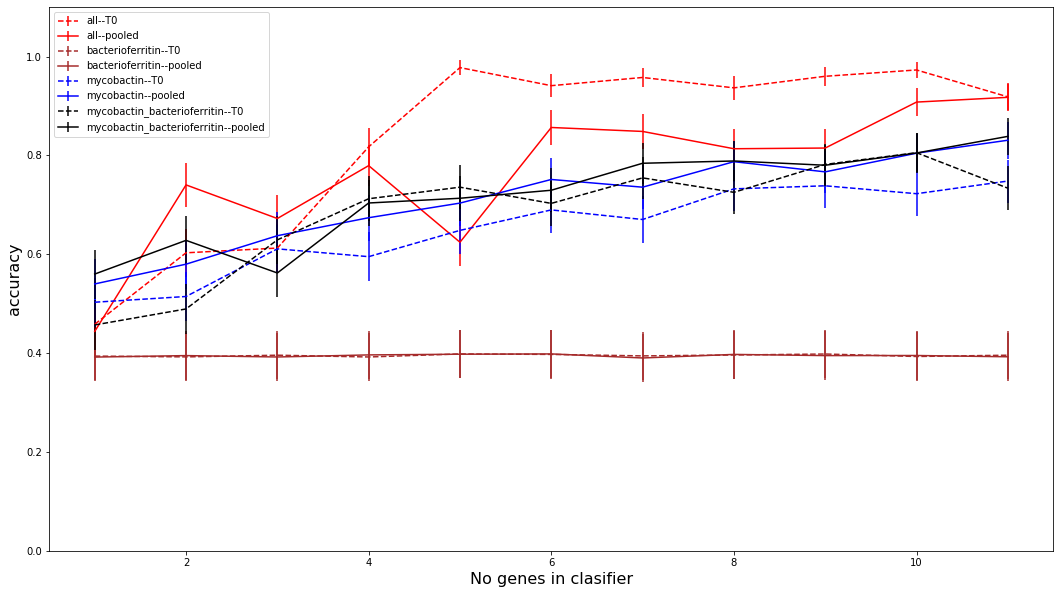

In [44]:
# Plot accuracy for the number of genes for each classifier
cv_data = CrossValidationData()
colors = ["red", "brown", "blue", "black"]
df_cv_data = cv_data.dataframe
_, ax = plt.subplots(1, figsize=(18, 10))
columns = list(df_cv_data.columns)
keys = ["%s--%s" % (k.split("--")[1], k.split("--")[0]) for k in columns]
df_new = df_cv_data.copy()
df_new.columns = keys
keys.sort()
for idx, key in enumerate(keys):
    color_idx = idx//2
    parts = key.split("--")
    yvals = df_new[key].values
    ystds = np.sqrt(yvals*(1-yvals)/cv_data.num_clf)
    if parts[1] == "T0":
        linestyle = "--"
    else:
        linestyle = "-"
    ax.errorbar(range(1, len(yvals)+1), yvals, yerr=ystds, linestyle=linestyle,
                color=colors[color_idx])
    ax.set_ylim([0, 1.1])
    _ = ax.set_xlabel("No genes in clasifier", fontsize=16)
    _ = ax.set_ylabel("accuracy", fontsize=16)
_ = ax.legend(keys)

**TODO**: 
1. Verify values plotted for coefficients.
1. Fix the legend
1. Find the genes associated with each point and see the genes necessary to reach plateau.

# Classifier Coefficients

In [ ]:
# Plot the classifier coefficients for each gene
nrow = 4
ncol = 2
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 15))
fig.tight_layout()
keys = []
irow = 0
for genes in ["mycobactin", "bacterioferritin", "mycobactin_bacterioferritin", "all"]:
    icol = 0
    for ref in ["T0", "pooled"]:
        key = (ref, genes)
        clf = CLASSIFIER_DCT[key]
        title = ", ".join(key)
        if icol == 1:
            is_legend = True
        else:
            is_legend = False
        ax = axes[irow, icol]
        clf.plotSVMCoefficients(title=title, ax=ax, class_names=STAGE_NAMES, is_plot=False)
        if irow < nrow - 1:
            ax.set_xticklabels([])
            ax.set_xlabel("")
        if icol > 0:
            ax.set_ylabel("")
        icol += 1
    irow += 1
plt.show()

**TO DO**: Note difference in roles of genes for each state based on pooled vs. TO.

The above chart displays the values of the SVM coefficients for each of the genes for the classifier used to identify each state. The vertical lines are error bars ($\pm$ 1 standard deviation) for the value of the coefficient over 100 classifiers constructed using 1 holdout per state.

The coefficients are used to identify the stage that best matches a gene expression vector. Given
an expression vector $\mathbf{x} = (x_1, \cdots, x_N)$, where $x_n \in [-1, 1 ]$ is the expression level of gene $x_n$ and
$c_{m,n}$ is the coefficient for the classifier for stage $m$ and gene $n$:
1. $d_m = \sum_n c_{m,n} x_n$
1. Choose stage $m^{\star}$ such that $m^{\star} = arg max_m \{ d_m \}$

In [ ]:
# Deeper look at training data
DATA_DCT[T0].plotExpressionLevels(CLASSIFIER.features, title="")

Several observations are of interest:
1. The coefficients for Transition are mostly negative, which means that this stage is about *under-expression*.
In particular, this stage is characterized by an under-expression of the genes Rv2383c, Rv2382c, Rv2386c, and Rv2385.
1. We see that Stage1a is characterized by large positive values of the coefficients for Rv2385, Rv3841, and Rv2384.
Although this makes sense for Rv2385, it is counter intuitive for
Rv2384 and Rv3841.
The rationale here is more complicated.
Rv2384 is not differentially expressed in Stage 1a; however, it is under-expressed in Transition.
So, a positive coefficient for Rv2384 for Stage 1a allows for differentiation from Transition.
A similar tactic seems to be in play for Rv3841 to distinguish Stage1a from Stage II and Resuscitation.
However, this is complicated by the fact that Transition over-expresses Rv3841.
The classifier compensates for this by having a large coefficient for Rv2384.

1. The other stages are characterized by a mixture of over- and under-expression.

# Accuracy of Gene Groups

In [ ]:
if False:
    gene_dct = {g: [g] for g in GENE_DCT["mycobactin"]}
    gene_dct.update(GENE_DCT)
    for name, genes in gene_dct.items():
        _, ax = plt.subplots(1)
        _ = accuracy_dct = plotAccuracy(genes, title=", ".join(genes), selected_stages=["StageII"], ax=ax, size=100)

In [ ]:
if False:
    gene_dct = {g: [g] for g in GENE_DCT["mycobactin"]}
    gene_dct.update(GENE_DCT)
    for name, genes in gene_dct.items():
        _, ax = plt.subplots(1)
        _ = accuracy_dct = plotAccuracy(genes, title=", ".join(genes), ax=ax, size=100)

In [ ]:
# Details for the 10 genes
if False:
    df_X = DF_X[GENE_DCT["mycobactin"]]
    num_genes = range(1, len(df_X.columns) + 1)
    num_genes = [10]
    for num_gene in num_genes:
        clf = classifier_ensemble.ClassifierEnsemble(
                classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=num_gene, size=100)
        clf.fit(df_X, SER_Y)
        evaluateClassifierOnInstances(clf, df_X=df_X, ser_y=SER_Y, class_names=STAGE_NAMES, nrow=4, ncol=6, is_plot=True)

## Evaluation for good performing genes

# Classification of Samples

In [ ]:
CLASSIFIER.features

In [ ]:
CLASSIFIER.predict(SAMPLE_DATA_DCT["AM_MDM"])

In [ ]:
reportSamplePredictions(SAMPLE_DCT[REF_TYPE_BIOREACTOR])

In [ ]:
reportSamplePredictions(SAMPLE_DCT[REF_TYPE_POOLED])

# Detailed Analyses

## GSE167232

In [ ]:
TRINARY.plotExpressionLevels(CLASSIFIER.features, df_X=SAMPLE_DATA_DCT["GSE167232"], title="GSE167232")

In [ ]:
TRINARY.plotExpressionLevels(CLASSIFIER.features, df_X=SAMPLE_DCT[REF_TYPE_POOLED]["GSE167232"], title="GSE167232")

In [ ]:
#CLASSIFIER.plotFeatureContributions(df_X.loc["TB_AM1",:], class_names=STAGE_NAMES)
df_predict = CLASSIFIER.predict(SAMPLE_DATA_DCT["GSE167232"])
indexArr = np.reshape(list(df_predict.index), (4,3))
num_row = 4
num_col =3
_, axes = plt.subplots(num_row, num_col, figsize=(20, 12))
for irow in range(4):
    for icol in range(3):
        if icol == 0:
            is_ylabel = True
        else:
            is_ylabel = False
        if icol == num_col - 1:
            is_legend = True
        else:
            is_legend = False
        if irow == num_row - 1:
            is_xlabel = True
        else:
            is_xlabel = False
        instance = indexArr[irow, icol]
        ser_X = SAMPLE_DATA_DCT["GSE167232"].loc[instance, :]
        CLASSIFIER.plotFeatureContributions(ser_X, class_names=STAGE_NAMES, title=instance, ax=axes[irow,icol], is_plot=False,
                                           is_xlabel=is_xlabel, is_ylabel=is_ylabel, is_legend=is_legend)
plt.show()

## Rustad

In [ ]:
for ref_type in [REF_TYPE_BIOREACTOR, REF_TYPE_POOLED]:
    _, ax = plt.subplots(1)
    df_X = SAMPLE_DCT[ref_type]["rustad"]
    # Select hypoxia samples
    sel =  ["H37Rv_hypoxia" in i and (not "10" in i) for i in df_X.index]
    df_X = df_X[sel]
    # Select just replication 1-3
    sel =  [any([r in i for r in ["rep1", "rep2", "rep3"]])  for i in df_X.index]
    df_X = df_X[sel]
    #
    replFunc = lambda i: i[-4:]
    timeFunc = lambda i: i[-9:-6].replace("_", "")
    #time_strs = ["4hr", "12hr", "1day", "4day", "7day"]
    title = "rustad: " + ref_type
    CLASSIFIER.plotReplicationsOverTime(df_X, replFunc, timeFunc, title=title, ax=ax)

## AM, MDM

In [ ]:
SAMPLE_DATA_DCT["AM_MDM"]

## Galagan

In [ ]:
for ref_type in [REF_TYPE_BIOREACTOR, REF_TYPE_POOLED]:
    df_X = SAMPLE_DCT[ref_type]["galagan"]
    prediction_df = CLASSIFIER.predict(df_X)
    replFunc = lambda i: i[-4:]
    timeFunc = lambda i: i[0:2]
    title = "galagan: " + ref_type
    _, ax = plt.subplots(1)
    CLASSIFIER.plotReplicationsOverTime(df_X, replFunc, timeFunc, title=title, ax=ax)

# Summary Comments

1. Choice of control
   1. Criteria for choice
1. Evaluating the quality of classification for test samples
   1. Consistency between replications
   1. Consistency in stage progression of replication
1. Detailed summaries for data sets
1. Selection of genes based on classification accuracy selects some, but not all of the mycobactin genes. 
   1. Which are not selected?
   1. What additional genes are selected?
   1. What are the signs and magnitudes of the mycobactin genes in the "all" case?
1. Using pooled data results in very different gene selections